In [1]:
using DataFrames
using CSV
using TextAnalysis
using MLJ
using Chain
using Pipe
using StableRNGs
using StringEncodings
using MLJText
using MLJBase
using Plots


In [2]:
df = CSV.File(open("sentiment_tweets3.csv", enc"ISO-8859-1")) |> DataFrame
rename!(df, [:Id, :Tweet, :Target])

df = select!(df, Not([:Id]))

df

Row,Tweet,Target
,String,Int64
1,"just had a real good moment. i missssssssss him so much,",0
2,is reading manga http://plurk.com/p/mzp1e,0
3,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
4,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
5,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
6,so sleepy. good times tonight though,0
7,"@SilkCharm re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now",0
8,23 or 24Ã¯Â¿Â½C possible today. Nice,0
9,nite twitterville workout in the am -ciao,0


In [3]:
df.Target = coerce(df.Target, OrderedFactor)
df.Tweet = TextAnalysis.StringDocument.(df[:, :Tweet])

levels(df.Target) 

2-element Vector{Int64}:
 0
 1

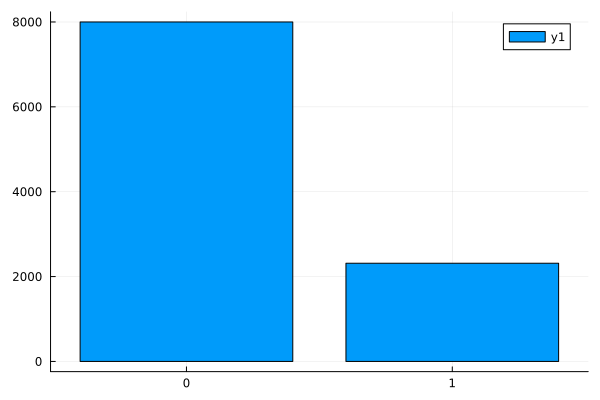

In [4]:
Plots.bar(["0", "1"], [nrow(df[(df.Target .== 0), :]), nrow(df[(df.Target .== 1), :])])

In [5]:
feat, target = MLJ.unpack(df, ==(:Tweet), ==(:Target))

(StringDocument{String}[A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}  …  A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}, A StringDocument{String}], CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 0×0 DataFrame)

# Data Cleaning

In [7]:
remove_case!.(feat)
TextAnalysis.remove_whitespace!.(feat)
remove_patterns!.(feat, r"(?<=\s|^)#[\p{L}\p{N}_]+")
remove_patterns!.(feat, r"@\w+")
prepare!.(feat, strip_indefinite_articles| strip_punctuation| strip_pronouns| strip_numbers| strip_non_letters| strip_stopwords| stem_words)

TextAnalysis.text(feat[7])

"re fiber home mean regular"

In [8]:
crps = Corpus(feat)

update_lexicon!(crps)

rng = StableRNG(100)
train, test = partition(eachindex(target), 0.7, shuffle=true, rng=rng);

# Multinomial Naive Bayes Classifier With TF-IDF Vectorizer

In [9]:
MultinomialNBClassifier = @load MultinomialNBClassifier pkg=NaiveBayes
multinomial_nb_classifier_pipe = (feat -> tokenize.(TextAnalysis.text.(feat))) |> TfidfTransformer() |> (feat -> round.(feat)) |> MultinomialNBClassifier()


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/OJDDo/src/loading.jl:159


import MLJNaiveBayesInterface ✔

ProbabilisticPipeline(
  f = var"#9#11"(), 
  tfidf_transformer = TfidfTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0, 
        smooth_idf = true), 
  f2 = var"#10#12"(), 
  multinomial_nb_classifier = MultinomialNBClassifier(
        alpha = 1), 
  cache = true)

In [16]:
mach = machine(multinomial_nb_classifier_pipe, feat, target)
MLJ.fit!(mach, rows=train)
params = fitted_params(mach)

params

┌ Info: Training machine(ProbabilisticPipeline(f = #9, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


┌ Info: Training machine(:tfidf_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


┌ Info: Training machine(:multinomial_nb_classifier, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


(multinomial_nb_classifier = (c_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Int64}(0 => 5601, 1 => 1621),
                              x_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Vector{Number}}(0 => [1, 3, 1, 1, 1, 3, 2, 1, 3, 4  …  3, 3, 1, 2, 2, 2, 1, 2, 2, 2], 1 => [2, 1, 3, 3, 3, 1, 1, 2, 1, 1  …  1, 1, 2, 1, 1, 1, 2, 1, 1, 1]),
                              x_totals = Number[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 5.0  …  4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
                              n_obs = 27944,),
 tfidf_transformer = (vocab = ["aaa", "aaaaaaaaaaaaa", "aaaaaaaand", "aaaaaah", "aaaaayyyyy", "aaaand", "aaah", "aaahhhh", "aaahhhhhh", "aahh"  …  "zomg", "zone", "zonepray", "zoo", "zoot", "zx", "zzz", "zzzz", "zzzzz", "zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz"],
                      idf_vector = [9.191601545891237, 9.191601545891237, 9.191601545891237, 9.191601545891237, 9.191601545891237, 9.191601545891237, 9.19160154

In [11]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), LogLoss()], rows=test)
println(evaluation)

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/resampling.jl:601


Evaluating over 6 folds:  33%[========>                ]  ETA: 0:00:40

Evaluating over 6 folds:  50%[============>            ]  ETA: 0:00:23

Evaluating over 6 folds:  67%[================>        ]  ETA: 0:00:13

Evaluating over 6 folds:  83%[====================>    ]  ETA: 0:00:06

Evaluating over 6 folds: 100%[=========================] Time: 0:00:31


PerformanceEvaluation(0.899, 0.771, 0.782, 0.776, 0.342)


Accuracy on the test set: 0.9573367808661927
fscore on the test set: 0.9016393442622951


MLJBase.ConfusionMatrixObject{2}(

[2357 89; 43 605], 

["0", "1"])


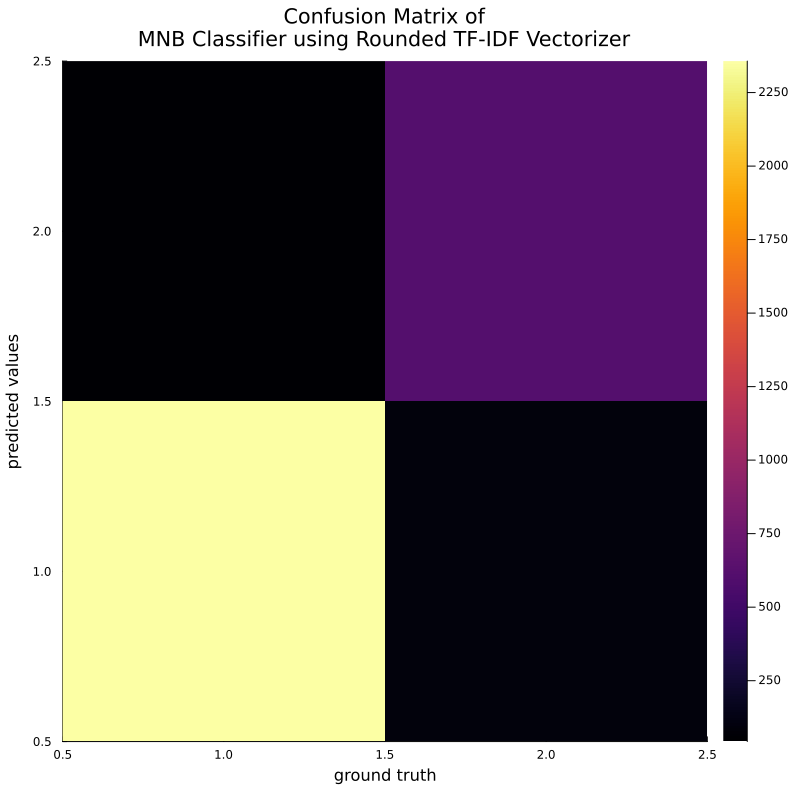

In [13]:
yhat = MLJ.predict(mach, rows=test)

println("Accuracy on the test set: $(MLJ.accuracy(mode.(yhat), target[test]))")
println("fscore on the test set: $(MLJ.f1score(mode.(yhat), target[test]))")

confusion_mat = ConfusionMatrix()(mode.(yhat), coerce(target[test], OrderedFactor))
println(confusion_mat)
cm_plt = Plots.heatmap(confusion_mat.mat, xlabel="ground truth", ylabel="predicted values", title="Confusion Matrix of\nMNB Classifier using Rounded TF-IDF Vectorizer", size= (800, 800))


# Multinomial Naive Bayes Classifier With Count Vectorizer

In [18]:
CountTransformer = @load CountTransformer pkg=MLJText
multinomial_nb_classifier_count_pipe = (feat -> tokenize.(TextAnalysis.text.(feat))) |> CountTransformer() |> MultinomialNBClassifier()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/bryan/.julia/packages/MLJModels/OJDDo/src/loading.jl:159


import MLJText ✔


ProbabilisticPipeline(
  f = var"#15#16"(), 
  count_transformer = CountTransformer(
        max_doc_freq = 1.0, 
        min_doc_freq = 0.0), 
  multinomial_nb_classifier = MultinomialNBClassifier(
        alpha = 1), 
  cache = true)

In [19]:
mach = machine(multinomial_nb_classifier_count_pipe, feat, target)
MLJ.fit!(mach, rows=train)
params = fitted_params(mach)

params

┌ Info: Training machine(ProbabilisticPipeline(f = #15, …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


┌ Info: Training machine(:count_transformer, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


┌ Info: Training machine(:multinomial_nb_classifier, …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/machines.jl:492


(multinomial_nb_classifier = (c_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Int64}(0 => 5601, 1 => 1621),
                              x_counts = Dict{CategoricalArrays.CategoricalValue{Int64, UInt32}, Vector{Number}}(0 => [1, 2, 1, 1, 1, 2, 2, 1, 2, 3  …  4, 2, 1, 2, 2, 2, 1, 2, 2, 2], 1 => [2, 1, 2, 2, 2, 1, 1, 2, 1, 1  …  1, 2, 2, 1, 1, 1, 2, 1, 1, 1]),
                              x_totals = Number[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0  …  5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
                              n_obs = 27944,),
 count_transformer = (vocab = ["aaa", "aaaaaaaaaaaaa", "aaaaaaaand", "aaaaaah", "aaaaayyyyy", "aaaand", "aaah", "aaahhhh", "aaahhhhhh", "aahh"  …  "zomg", "zone", "zonepray", "zoo", "zoot", "zx", "zzz", "zzzz", "zzzzz", "zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz"],),)

In [20]:
evaluation = evaluate!(mach, resampling=CV(), measure=[Accuracy(), Precision(), TruePositiveRate(), FScore(), LogLoss()], rows=test)
println(evaluation)

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/WKVEo/src/resampling.jl:601


Evaluating over 6 folds:  33%[========>                ]  ETA: 0:00:16

Evaluating over 6 folds:  50%[============>            ]  ETA: 0:00:11

Evaluating over 6 folds:  67%[================>        ]  ETA: 0:00:07

Evaluating over 6 folds:  83%[====================>    ]  ETA: 0:00:03

Evaluating over 6 folds: 100%[=========================] Time: 0:00:20


PerformanceEvaluation(0.967, 0.91, 0.949, 0.929, 0.112)


Accuracy on the test set: 0.9912734324499031
fscore on the test set: 0.9806451612903225
MLJBase.ConfusionMatrixObject{2}([2383 10; 17 684], ["0", "1"])


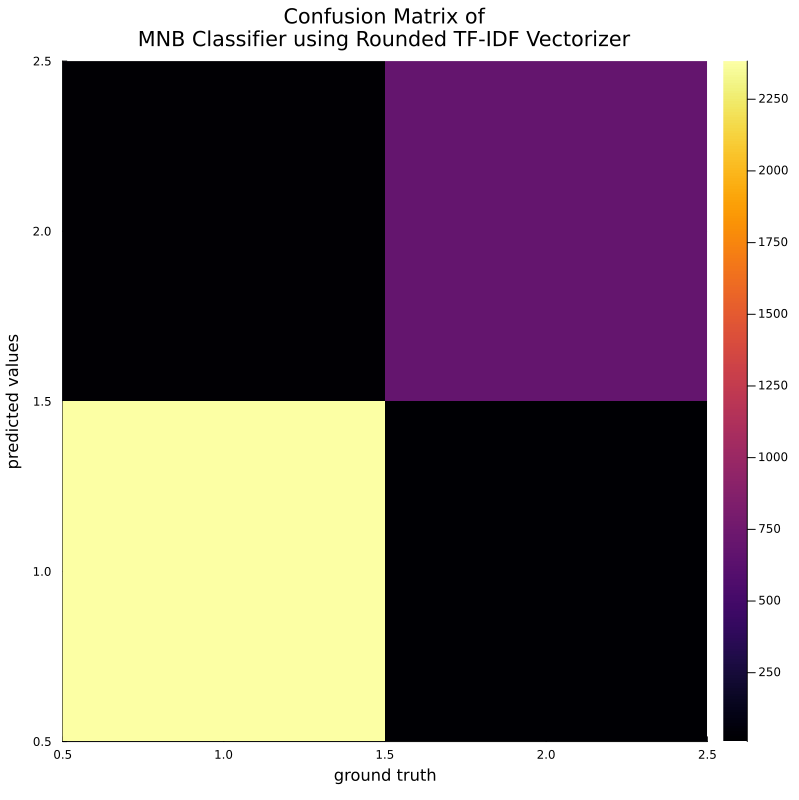

In [21]:
yhat = MLJ.predict(mach, rows=test)

println("Accuracy on the test set: $(MLJ.accuracy(mode.(yhat), target[test]))")
println("fscore on the test set: $(MLJ.f1score(mode.(yhat), target[test]))")

confusion_mat = ConfusionMatrix()(mode.(yhat), coerce(target[test], OrderedFactor))
println(confusion_mat)
cm_plt = Plots.heatmap(confusion_mat.mat, xlabel="ground truth", ylabel="predicted values", title="Confusion Matrix of\nMNB Classifier using Rounded TF-IDF Vectorizer", size= (800, 800))